<a href="https://colab.research.google.com/github/lkhart/kaggle_digit_recognizer/blob/main/digit_recognizer_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digit Recognizer**

#### [Kaggle Competition Entry](https://www.kaggle.com/c/digit-recognizer/overview)/Class Assignment 
#### Laura Hart - MSDS 422 - Winter 2022

The objective of this exercise is to apply classification techniques to correctly identify digits (0-9) from a dataset of tens of thousands of handwritten images. Each image is 28x28 pixels in size, and each pixel is represented in the dataset as one column (pixel0, pixel1, ..., pixel784). The value within that column represents the darkness of that pixel, with values ranging from 0 (lightest) to 255 (darkest). One row of pixel values represents one 28x28pixel image of a handwritten digit.

## Management/Research Question: Practical Application
This classification problem can be applied to numerous real-world problems, such as automatic mail sorting or converting handwritten files to a digital format. A successful classifier model must be able to correctly label digits written in different sizes and styles; the appearance of a digit is not expected to be consistent, but a successful model will identify the patterns that distinguish each label from the others.

## Setup

In [1]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras import utils

In [3]:
train_df = pd.read_csv('train.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# train_df details (number of rows used later)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
test_df = pd.read_csv('test.csv')
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# test_df details (number of rows used later)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


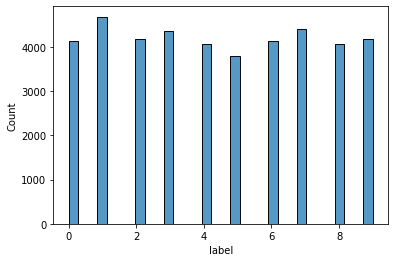

In [ ]:
# distribution of label value in train data
sns.histplot(x='label', data=train_df)

As displayed in the above plot, the label values appear to are nearly uniformly distributed among the training data. There is no class imbalance within the dataset, and no corrective sampling technique will be needed when splitting the data into train/validation sets.

## Modeling 

We will conduct multiple experiments to evaluate the performance of various neural networks by changing the layers and nodes. Tested neural networks should be explored within a benchmark experiment, a 2x2 completely crossed design.

### Prep data for modeling

First, we split the 'train_df' data into training (80%) and test/validation (20%) subsets.

In [5]:
# set seed for reproducibility
np.random.seed(123)
# train-test split
X_train, X_test, y_train, y_test = train_test_split(train_df.iloc[:, 1:], train_df.iloc[:, 0], test_size=0.20)

Next, in order to prepare this data for experimenting with neural networks, we need to adjust the output labels from a single column that contains labels 0-9 into a one-hot encoded vector with binary values representing the digit category.

In [ ]:
print(X_train.shape)

(33600, 784)


In [ ]:
print(X_test.shape)

(8400, 784)


In [6]:
# convert to one-hot vectors using to_categorical function
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("First 5 training labels as one-hot encoded vectors:\n", y_train[:5])


First 5 training labels as one-hot encoded vectors:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [7]:
# normalize x values
X_train = X_train/255
X_test = X_test/255

### Experiment design: Neural Network
We will conduct an experiment that tests three different values for layers {1, 2, 5} and five values for nodes {10, 20, 50, 100, 200}.

We will compare these models by their execution time, training accuracy, and testing accuracy.

In [12]:
def model_build(nnodes, nlayers):
  if nlayers == 1:
    model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[784,]),
      keras.layers.Dense(nnodes, activation="relu"),
      keras.layers.Dense(10, activation="softmax")
      ])
  elif nlayers == 2:
    model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[784,]),
      keras.layers.Dense(nnodes, activation="relu"),
      keras.layers.Dense(nnodes, activation="relu"),
      keras.layers.Dense(10, activation="softmax")
      ])
  elif nlayers == 5:
    model = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[784,]),
      keras.layers.Dense(nnodes, activation="relu"),
      keras.layers.Dense(nnodes, activation="relu"),
      keras.layers.Dense(nnodes, activation="relu"),
      keras.layers.Dense(nnodes, activation="relu"),
      keras.layers.Dense(nnodes, activation="relu"),
      keras.layers.Dense(10, activation="softmax")
      ])
  else:
    print('layer values must be in 1, 2, 5')
  
  return model

In [13]:
experiment_df = pd.DataFrame()
layers_to_try = [1, 2, 5]
nodes_to_try = [10, 20, 50, 100, 200]

In [14]:
for layer in layers_to_try:
  for node in nodes_to_try:
    print(layer)
    print(node)
    
    model = model_build(node, layer)

    # compiler
    model.compile(loss="categorical_crossentropy", # used for labels in one_hot format
                  optimizer="adam",
                  metrics=["accuracy"])
    
    # fit model
    start = datetime.now()
    history = model.fit(X_train, y_train, epochs=20, verbose=2, validation_data=(X_test, y_test))
    end = datetime.now()
    elapsed_time = end-start

    # append model to experiment df
    experiment_df = experiment_df.append({'layers': layer,
                                          'node': node,
                                          'time': elapsed_time,
                                          'train_accuracy': history.history['accuracy'][-1],
                                          'val_accuracy': history.history['val_accuracy'][-1]
                                          },
                                         ignore_index=True)

1
10
Epoch 1/20
1050/1050 - 6s - loss: 0.6885 - accuracy: 0.7951 - val_loss: 0.3679 - val_accuracy: 0.8961 - 6s/epoch - 5ms/step
Epoch 2/20
1050/1050 - 3s - loss: 0.3299 - accuracy: 0.9051 - val_loss: 0.3142 - val_accuracy: 0.9106 - 3s/epoch - 3ms/step
Epoch 3/20
1050/1050 - 2s - loss: 0.2924 - accuracy: 0.9157 - val_loss: 0.2889 - val_accuracy: 0.9176 - 2s/epoch - 2ms/step
Epoch 4/20
1050/1050 - 2s - loss: 0.2729 - accuracy: 0.9214 - val_loss: 0.2829 - val_accuracy: 0.9215 - 2s/epoch - 2ms/step
Epoch 5/20
1050/1050 - 3s - loss: 0.2588 - accuracy: 0.9258 - val_loss: 0.2788 - val_accuracy: 0.9218 - 3s/epoch - 3ms/step
Epoch 6/20
1050/1050 - 2s - loss: 0.2471 - accuracy: 0.9290 - val_loss: 0.2708 - val_accuracy: 0.9250 - 2s/epoch - 2ms/step
Epoch 7/20
1050/1050 - 2s - loss: 0.2372 - accuracy: 0.9329 - val_loss: 0.2673 - val_accuracy: 0.9271 - 2s/epoch - 2ms/step
Epoch 8/20
1050/1050 - 2s - loss: 0.2295 - accuracy: 0.9350 - val_loss: 0.2621 - val_accuracy: 0.9265 - 2s/epoch - 2ms/step
Epo

In [15]:
experiment_df

,layers,node,time,train_accuracy,val_accuracy
0,1.0,10.0,0 days 00:00:46.224553,0.948036,0.934048
1,1.0,20.0,0 days 00:00:42.239039,0.973661,0.951429
2,1.0,50.0,0 days 00:00:49.215500,0.996786,0.969524
3,1.0,100.0,0 days 00:00:53.297743,0.998452,0.972619
4,1.0,200.0,0 days 00:01:22.657473,0.999316,0.975357
5,2.0,10.0,0 days 00:00:42.292133,0.949792,0.927738
6,2.0,20.0,0 days 00:00:42.138914,0.978839,0.950952
7,2.0,50.0,0 days 00:01:22.724863,0.994851,0.968095
8,2.0,100.0,0 days 00:00:57.962207,0.996518,0.975119
9,2.0,200.0,0 days 00:01:21.829136,0.997679,0.971429


The configuration that appears to perform best on the validation set is 200 nodes and 1 layer. This will be the configuration I apply to the final test set. 

In [16]:
# create final model with best configurations from testing
model_final = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[784,]),
      keras.layers.Dense(200, activation="relu"),
      keras.layers.Dense(10, activation="softmax")
      ])

In [17]:
# compiler
model_final.compile(loss="categorical_crossentropy", # used for labels in one_hot format
              optimizer="adam",
              metrics=["accuracy"])

In [18]:
# fit model
start = datetime.now()
history = model_final.fit(X_train, y_train, epochs=20, verbose=2, validation_data=(X_test, y_test))
end = datetime.now()
elapsed_time = end-start

print(elapsed_time)

Epoch 1/20
1050/1050 - 4s - loss: 0.2966 - accuracy: 0.9145 - val_loss: 0.1633 - val_accuracy: 0.9517 - 4s/epoch - 4ms/step
Epoch 2/20
1050/1050 - 3s - loss: 0.1312 - accuracy: 0.9613 - val_loss: 0.1217 - val_accuracy: 0.9644 - 3s/epoch - 3ms/step
Epoch 3/20
1050/1050 - 3s - loss: 0.0851 - accuracy: 0.9751 - val_loss: 0.1124 - val_accuracy: 0.9652 - 3s/epoch - 3ms/step
Epoch 4/20
1050/1050 - 3s - loss: 0.0611 - accuracy: 0.9821 - val_loss: 0.0991 - val_accuracy: 0.9707 - 3s/epoch - 3ms/step
Epoch 5/20
1050/1050 - 3s - loss: 0.0453 - accuracy: 0.9864 - val_loss: 0.0944 - val_accuracy: 0.9740 - 3s/epoch - 3ms/step
Epoch 6/20
1050/1050 - 3s - loss: 0.0346 - accuracy: 0.9898 - val_loss: 0.0938 - val_accuracy: 0.9737 - 3s/epoch - 3ms/step
Epoch 7/20
1050/1050 - 3s - loss: 0.0251 - accuracy: 0.9919 - val_loss: 0.0864 - val_accuracy: 0.9745 - 3s/epoch - 3ms/step
Epoch 8/20
1050/1050 - 3s - loss: 0.0192 - accuracy: 0.9946 - val_loss: 0.0979 - val_accuracy: 0.9740 - 3s/epoch - 3ms/step
Epoch 9/

Use the final model to predict on X_test

In [19]:
y_pred = model_final.predict(X_test)

In [20]:
y_pred

array([[2.2769495e-17, 3.9451070e-08, 9.9999976e-01, ..., 8.3182288e-16,
        3.2476433e-13, 1.7491639e-17],
       [7.6615519e-14, 4.0981068e-12, 9.9999928e-01, ..., 7.0537300e-07,
        4.4062250e-11, 2.2548597e-13],
       [1.0000000e+00, 3.4266859e-31, 2.0091626e-18, ..., 6.3725105e-15,
        2.6517061e-25, 3.6858868e-13],
       ...,
       [1.9355164e-14, 4.7396756e-16, 1.4144370e-18, ..., 1.3769894e-17,
        5.2618435e-13, 1.0221859e-09],
       [9.9994516e-01, 1.7675599e-18, 2.5479960e-11, ..., 5.4797641e-05,
        4.4300799e-14, 1.6979621e-08],
       [1.5919024e-07, 5.3165664e-19, 7.0368891e-11, ..., 3.5332178e-11,
        3.6756032e-12, 9.9999988e-01]], dtype=float32)

In [21]:
y_pred = np.argmax(y_pred, axis=1) # get categorical value from one-hot format

In [22]:
y_pred

array([2, 2, 0, ..., 5, 0, 9])

In [24]:
y_test_cat = np.argmax(y_test, axis=1)

In [25]:
y_test_cat

array([2, 2, 0, ..., 5, 0, 9])

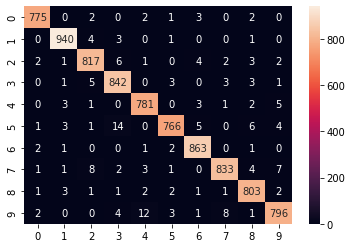

In [26]:
# confusion matrix
cm = confusion_matrix(y_test_cat, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

The confusion matrix shows what categories were confused for each other most often in the model. The values that stand out as being classified incorrectly most often are true 3's being incorrectly predicted to be 5's (14 times), and true 4's being incorrectly predicted to be 9's (12 times). 

In [27]:
print(classification_report(y_test_cat, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       785
           1       0.99      0.99      0.99       949
           2       0.97      0.97      0.97       838
           3       0.97      0.98      0.97       858
           4       0.97      0.98      0.98       796
           5       0.98      0.96      0.97       800
           6       0.98      0.99      0.99       870
           7       0.98      0.97      0.98       860
           8       0.97      0.98      0.98       817
           9       0.97      0.96      0.97       827

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



Goodness of fit metrics show that this model is highly accurate (final overall accuracy .98), and that precision and recall scores have minimal variation among categories. 

Use the final model to predict on the unseen test_df set.

In [28]:
# standardize
test_df = test_df/255

In [33]:
final_pred = model_final.predict(test_df)

In [34]:
final_pred_list = []
for i in range(0, len(final_pred)):
  final_pred_list.append(np.argmax(final_pred[i])) # convert from one-hot to digit

In [36]:
Id = []
for i in range(1, len(final_pred_list) + 1):
  Id.append(i)

In [38]:
final_pred_df = pd.DataFrame(list(zip(Id, final_pred_list)), columns = ['ImageId', 'Label'])

In [39]:
final_pred_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [40]:
# export final predicitions
final_pred_df.to_csv('final_pred.csv', index=False)

files.download('final_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

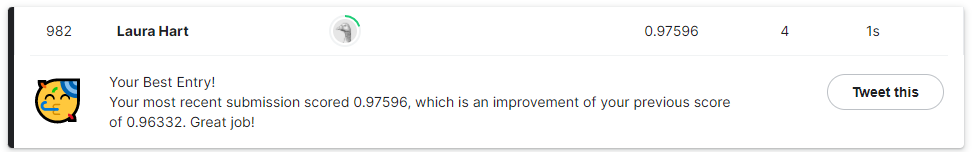